In [195]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
from matplotlib import cm
from skimage.feature import match_template



In [196]:
def show(img, cmap=None):
  plt.imshow(img) if cmap is None else plt.imshow(img, cmap=cmap)
  plt.show()

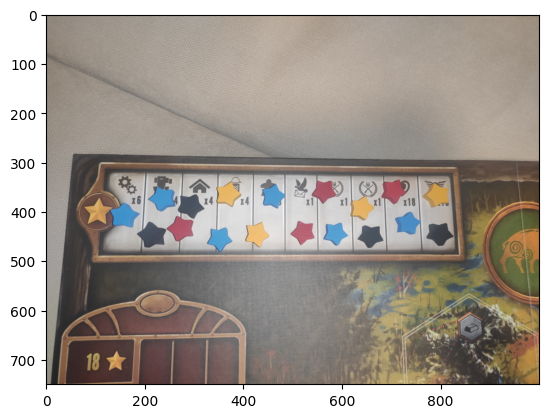

In [197]:
%matplotlib inline
img = cv.imread('stars/stars_2.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = np.uint8(rescale(img, (0.25,0.25,1))*255)

plt.imshow(img)
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

## Cut the board from the image

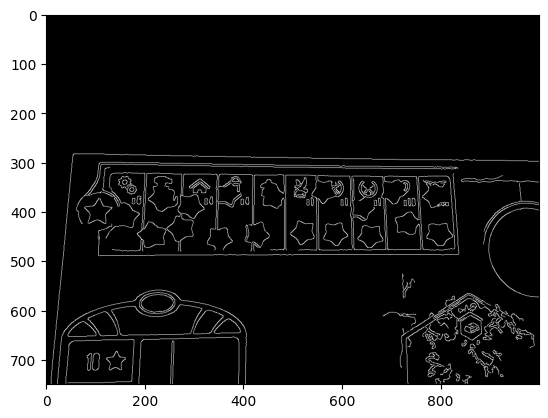

In [198]:
# hue_min,hue_max,lit_min,lit_max,sat_min,sat_max = \
#   0, 40, 40, 210, 100, 170
# boundary_img = mask_coins_hsv(hue_min,hue_max,lit_min,lit_max,sat_min,sat_max)
# gray = cv.cvtColor(boundary_img, cv.COLOR_RGB2GRAY)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
# show(gray,'gray')
blurred = cv.GaussianBlur(gray, ksize=(7,7),sigmaX=0,sigmaY=0)
# show(blurred,'gray')
edges = cv.Canny(blurred,20,150)
show(edges,'gray')

In [199]:
# two auxilary functions
def get_line(a, b, x_lim, y_lim=None):
    x = np.linspace(*x_lim)
    y = a * x + b
    if y_lim is not None:
        y = y[y>=y_lim[0]]
        y = y[y<=y_lim[1]]
    return x, y

def hough_thetaro_to_ab(theta, ro):
    a = -1 /np.tan(theta)
    b = ro / np.sin(theta)
    return a, b

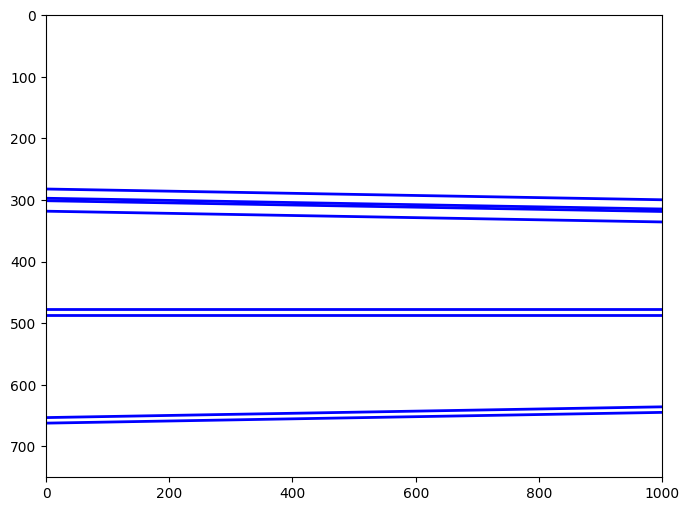

In [200]:
borders_hough = np.ones_like(img, dtype=np.uint8)*255

lines = cv.HoughLines(edges,1,np.pi/180,200)
lines = list(lines)
lines = list(filter(lambda x: x[0,1] !=0, lines))
lines = np.concatenate(lines, axis=0)
y_max, x_max = borders_hough.shape[:-1]

plt.figure(figsize = (8,6))
plt.imshow(borders_hough)
for i, line in enumerate(lines):
    ro, theta = line
    a, b = hough_thetaro_to_ab(theta, ro)
    plt.plot(*get_line(a, b, [0, x_max]), 'b', lw=2)

plt.xlim([0, x_max])
plt.ylim([y_max, 0])
plt.show()

In [201]:
from skimage.measure import LineModelND, ransac
# convert all lines to a-b space
ab_selected = np.array(
    [hough_thetaro_to_ab(theta, ro)
     for ro, theta in lines if theta != 0]
)
# look for inliers using a linear model
model, inliers = ransac(ab_selected, LineModelND, min_samples=2, residual_threshold=0.01)

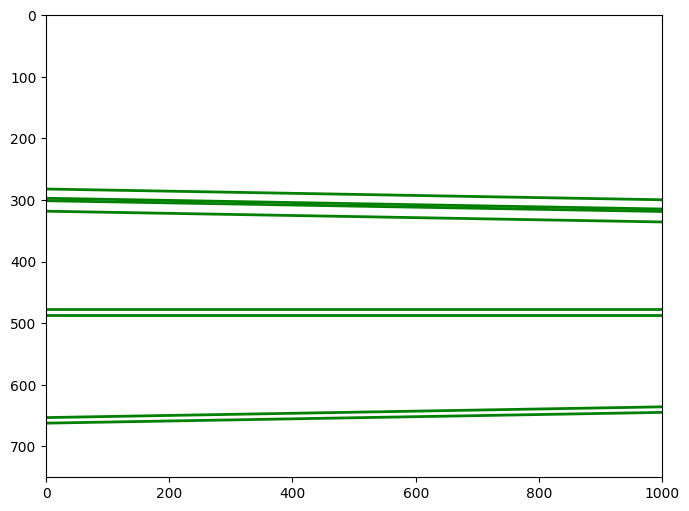

In [202]:
y_max, x_max = borders_hough.shape[:-1]

plt.figure(figsize = (8,6))
plt.imshow(borders_hough)

for i,line in enumerate(lines):
    ro, theta = line
    if theta !=0:
        a, b = hough_thetaro_to_ab(theta, ro)
        color = 'g' if inliers[i] else 'r'
        plt.plot(*get_line(a, b, [0, x_max]), color, lw=2)

plt.xlim([0, x_max])
plt.ylim([y_max, 0])
plt.show()

In [203]:
#transform
lines_ab_final = ab_selected[inliers]

points_current = []
points_desired = []

for i, ab in enumerate(lines_ab_final):
    # the points for the left of the image (x=0)
    # y = a*x+b
    y_0 = ab[1]
    points_current.append([0, y_0])
    points_desired.append([0, y_0])
    # the points for the right of the image (x=x_max)
    points_current.append([x_max, ab[0]*x_max+ab[1]])
    points_desired.append([x_max, y_0])

points_current = np.array(points_current)
points_desired = np.array(points_desired)

In [192]:
from skimage.transform import ProjectiveTransform, warp
tform = ProjectiveTransform()
tform.estimate(points_desired, points_current)
image_warped = warp(img, tform)

In [193]:
y_borders = int(np.min(points_desired[:,1])), int(np.max(points_desired[:,1]))
image_warped_cut = image_warped[y_borders[0]:y_borders[1]]

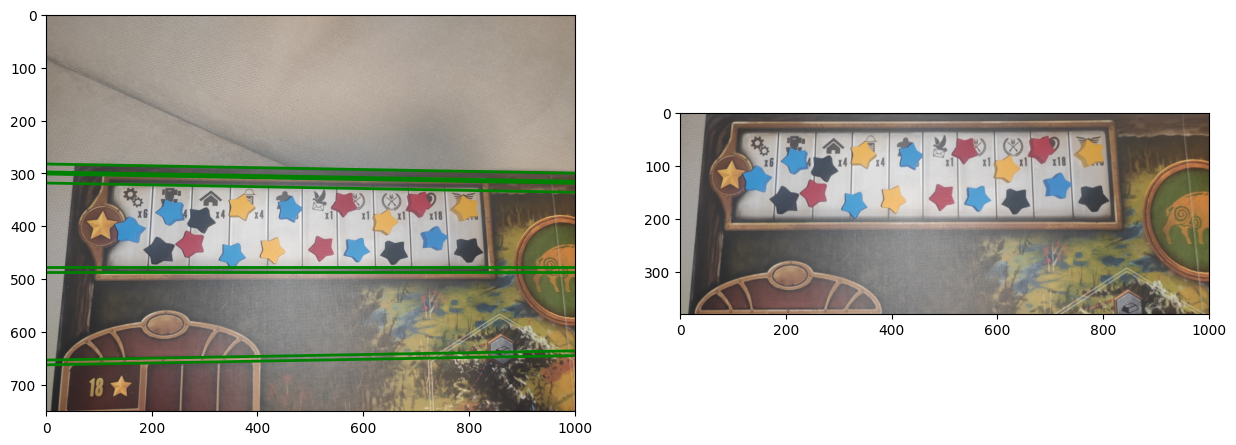

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(img)
ax[1].imshow(image_warped_cut)

for i in range(len(points_current)//2):
    ax[0].plot(*points_current[i*2:i*2+2].T, 'g', lw=2)
    # ax[1].plot(*points_desired[i*2:i*2+2].T, 'g', lw=2)

ax[0].set_xlim([0, x_max])
ax[0].set_ylim([y_max, 0])

ax[1].set_xlim(0, x_max)
# ax[1].set_ylim([y_borders[1], y_borders[0]])

plt.show()

## Color sigmentation for stars

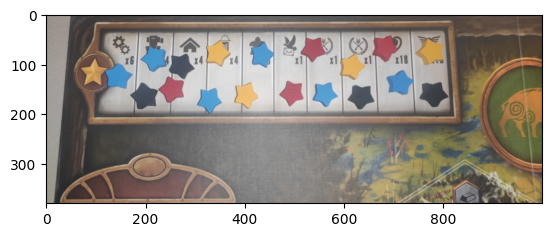

In [204]:
img = np.uint8(image_warped_cut*255)
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
show(img)

In [205]:
from ipywidgets import IntSlider, interact

hue_min = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
hue_max = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
lit_min = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
lit_max = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
sat_min = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
sat_max = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)

def mask_coins_hsv(hue_min,hue_max,lit_min,lit_max,sat_min,sat_max):

  mask = cv.inRange(img_hsv, (hue_min,lit_min,sat_min),(hue_max,lit_max,sat_max))
  result = cv.bitwise_and(img, img, mask=mask)
  # plt.figure(dpi=200)
  plt.subplot(2,2,1)
  plt.imshow(img)
  plt.title('image ')
  plt.axis('off')
  plt.subplot(2,2,2)
  plt.imshow(result)
  plt.title('masked ')
  plt.axis('off')
  plt.subplot(2,2,3)
  plt.imshow(mask)
  plt.title('mask ')
  plt.axis('off')
  plt.show()
  return result


r_min = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
r_max = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
g_min = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
g_max = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
b_min = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)
b_max = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)

def mask_coins_rgb(r_min,r_max,g_min,g_max,b_min,b_max):

  mask = cv.inRange(img, (r_min,g_min,b_min),(r_max,g_max,b_max))
  result = cv.bitwise_and(img, img, mask=mask)
  # plt.figure(dpi=200)
  plt.subplot(2,2,1)
  plt.imshow(img)
  plt.title('image ')
  plt.axis('off')
  plt.subplot(2,2,2)
  plt.imshow(result)
  plt.title('masked ')
  plt.axis('off')
  plt.subplot(2,2,3)
  plt.imshow(mask)
  plt.title('mask ')
  plt.axis('off')
  plt.show()
  return result

In [206]:
%matplotlib inline
interact(mask_coins_rgb, r_min=r_min,r_max=r_max,g_min=g_min,
         g_max=g_max,b_min=b_min,b_max=b_max);

interactive(children=(IntSlider(value=100, continuous_update=False, description='r_min', max=255), IntSlider(v…

In [207]:
%matplotlib inline
result = interact(mask_coins_hsv, hue_min=hue_min,hue_max=hue_max,lit_min=lit_min,
         lit_max=lit_max,sat_min=sat_min,sat_max=sat_max);

interactive(children=(IntSlider(value=100, continuous_update=False, description='hue_min', max=255), IntSlider…

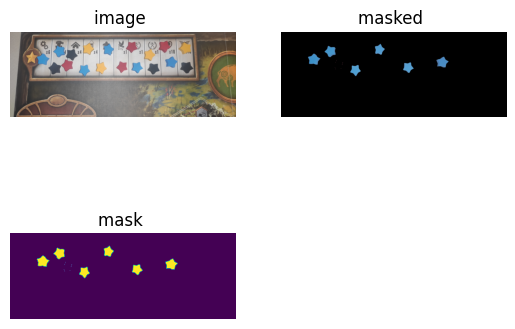

In [208]:
hue_min,hue_max,lit_min,lit_max,sat_min,sat_max = \
      90, 172, 113, 202, 83, 255
blue = mask_coins_hsv(hue_min,hue_max,lit_min,lit_max,sat_min,sat_max)


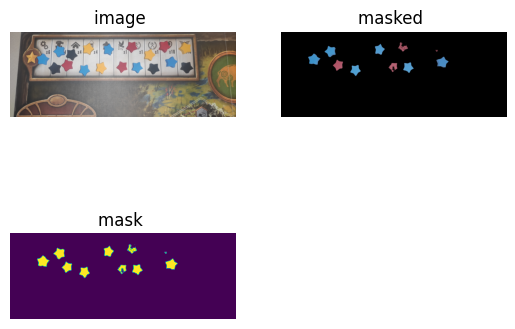

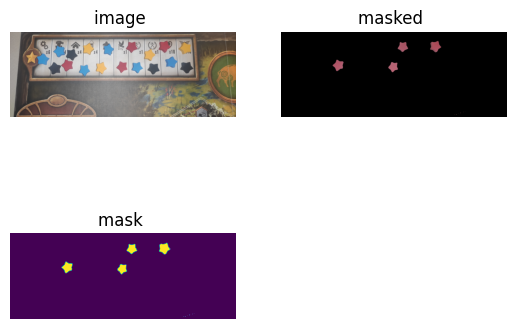

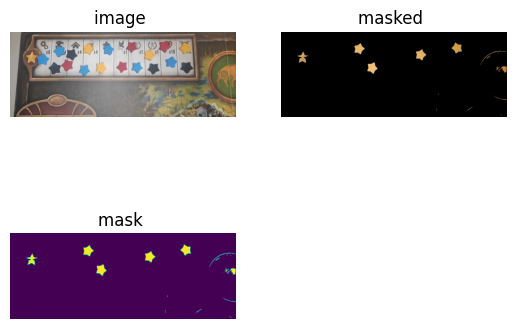

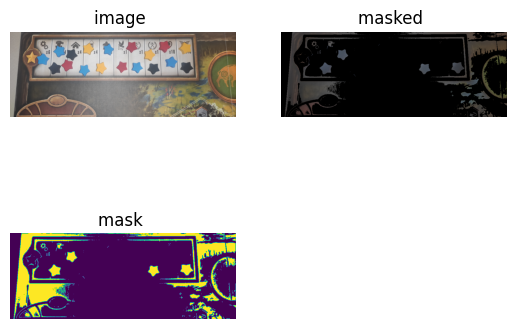

In [209]:
hue_min,hue_max,lit_min,lit_max,sat_min,sat_max = \
      90, 172, 113, 202, 83, 255
blue = mask_coins_hsv(hue_min,hue_max,lit_min,lit_max,sat_min,sat_max)

hue_min,hue_max,lit_min,lit_max,sat_min,sat_max = \
  150, 200, 100, 200, 83, 190
red = mask_coins_hsv(hue_min,hue_max,lit_min,lit_max,sat_min,sat_max)

hue_min,hue_max,lit_min,lit_max,sat_min,sat_max = \
  0, 50, 91, 200, 195, 255
yellow = mask_coins_hsv(hue_min,hue_max,lit_min,lit_max,sat_min,sat_max);

r_min,r_max,g_min,g_max,b_min,b_max = \
  49,91,49,167,45,115
black = mask_coins_rgb(r_min,r_max,g_min,g_max,b_min,b_max);

In [128]:
template = cv.imread(f'stars/templates/black_template.png',0)


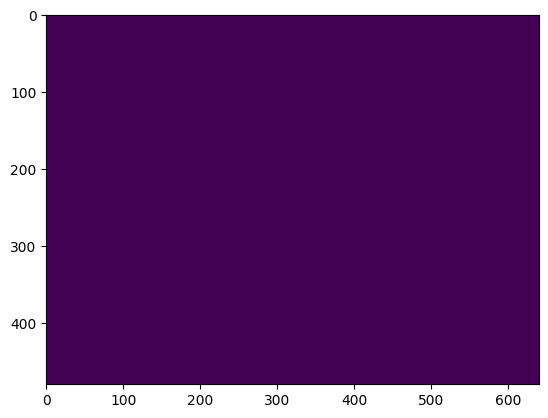

In [129]:
show(template)

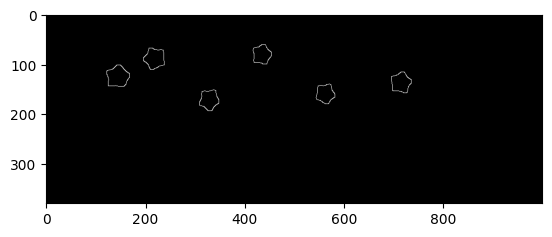

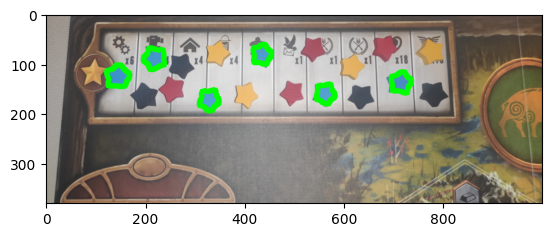

blue: n_contours=6, mean_area=1216.75, max_area=1472.5, min_area=1072.5


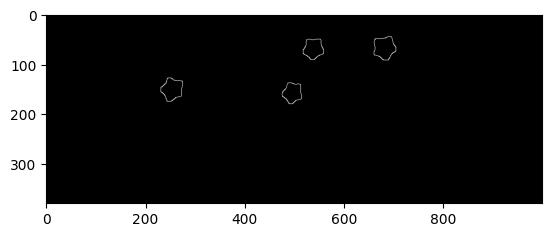

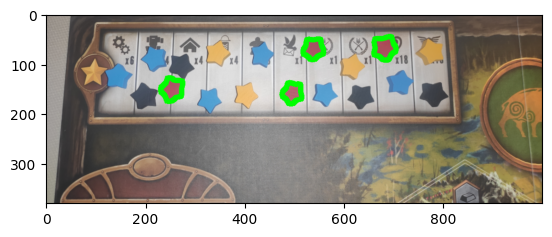

red: n_contours=4, mean_area=1357.38, max_area=1542.5, min_area=1189.0


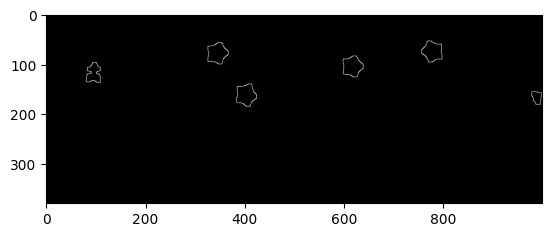

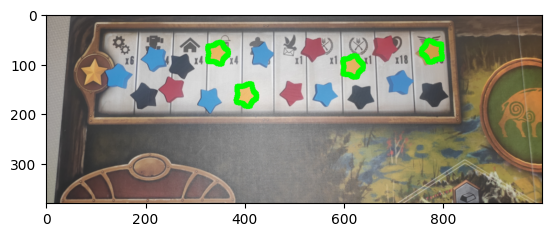

yellow: n_contours=4, mean_area=1266.00, max_area=1305.5, min_area=1242.0


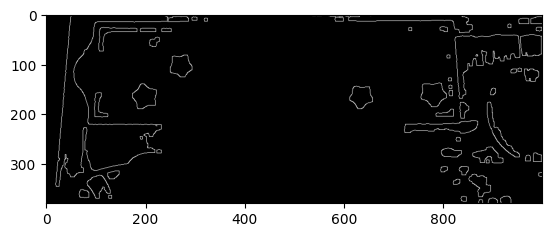

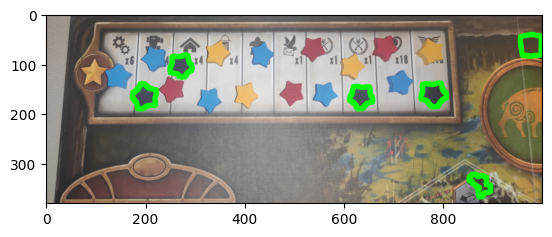

black: n_contours=6, mean_area=1499.08, max_area=1735.0, min_area=1058.0


In [100]:
def is_bound_box_ratio_good(contour):
    cv.boxPoints(cv.minAreaRect(contour))
    _,_,w,h = cv.boundingRect(contour)
    return h !=0 and w !=0 and 0.8<w/h<1.3

for color, colorname in zip([blue,red,yellow, black],['blue','red','yellow','black']):
  gray = cv.cvtColor(color, cv.COLOR_RGB2GRAY)
  gray = cv.morphologyEx(gray, cv.MORPH_OPEN, np.ones((7,7)))
  gray = cv.morphologyEx(gray, cv.MORPH_OPEN, np.ones((7,7)))

  blurred = cv.GaussianBlur(gray, ksize=(5,5),sigmaX=0,sigmaY=0)
  edges = cv.Canny(blurred, 15, 120)
  show(edges,'gray')
  contours, hierarchy = cv.findContours(edges,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cont_areas =[]
  img_cont = img.copy()
  contours = list(filter(lambda x: cv.contourArea(x)>500,contours))
  contours = list(filter(lambda x: cv.contourArea(x)<3000,contours))
  contours = list(filter(is_bound_box_ratio_good,contours))
  
  for contour in contours:
    cont_area = cv.contourArea(contour)
    cont_areas.append(cont_area)
  cv.drawContours(img_cont, contours, -1, (0, 255,0),10)
  show(img_cont)
  if len(cont_areas) !=0:
    mean_area = np.mean(cont_areas)
    min_area = np.min(cont_areas)
    max_area = np.max(cont_areas)
  else:
    mean_area = 0
    min_area = 0
    max_area = 0

  print(f'{colorname}: n_contours={len(contours)}, {mean_area=:5.2f}, {max_area=}, {min_area=}')

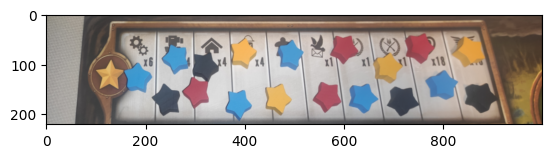

In [190]:
show(img)

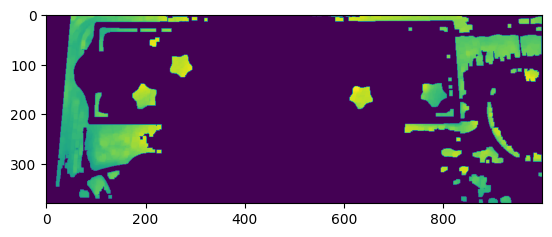

In [136]:
gray = cv.cvtColor(black, cv.COLOR_RGB2GRAY)
gray = cv.morphologyEx(gray, cv.MORPH_OPEN, np.ones((7,7)))
show(gray)

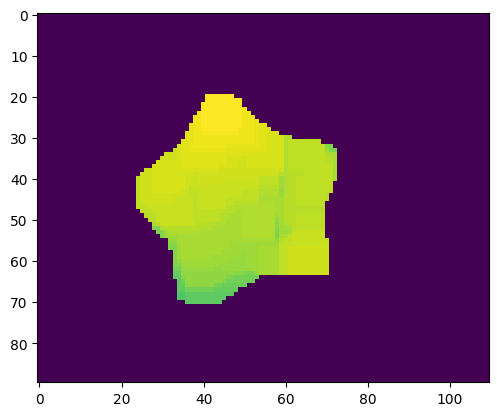

In [144]:
black_template = gray[120:210,150:260]
show(black_template)
with open('stars/templates/black.npy','wb') as f:
  np.save(f, black_template)

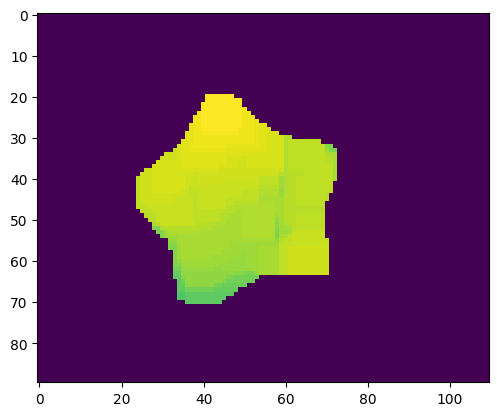

In [147]:
k = np.load('stars/templates/black.npy')
show(k)

In [200]:
from skimage.feature import match_template

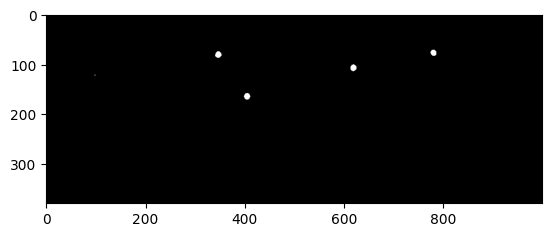

5


In [125]:
# black_gray = cv.cvtColor(black_, cv.COLOR_RGB2GRAY)
# black_template_gray = cv.cvtColor(black_template, cv.COLOR_RGB2GRAY)
# show(black_gray,'gray')
# show(black_template_gray,'gray')
corr_skimage = match_template(gray, black_template, pad_input=True)
matches = corr_skimage>0.7
show(np.uint8(matches*255), 'gray')

# edges = cv.Canny(np.uint8(matches*255), 20, 150)
# show(edges)
contours, hierarchy = cv.findContours(np.uint8(matches*255),cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
print(len(contours))